# CNN Interactive Tutorial

Original credits to CSC421 and Utku Ozbulak and John Chen. Verified working Feb 4th 2021 by Yun-Chun Chen

# Overview



1.   Motivating Convolution
2.   Two views of a conv layer
3.   Hacker's guide to convnets: Dimension Matching (and FCN)
4.   Visualizations and Adversarial attacks 



## Using this Notebook

Simply download the notebook by going to File -> Download .ipynb
Then reupload to colab on your own

In [ ]:
!pip install livelossplot

## Understanding convolutions

Suppose an input image has the follow features:

$\begin{bmatrix}
0 & 10  & 9 & 10 & 0 \\
0 & 0  & 0 & 10 & 0 \\
0 & 10  & 9 & 10 & 0 \\
0 & 0  & 0 & 10 & 0 \\
0 & 10  & 9 & 10 & 0 \\
\end{bmatrix}
$

and we use the following $3 \times 3$ filter with stride 1:
$\begin{bmatrix}
0 & 1  & 0\\
0 & 1  & 0 \\
0 & 1  & 0 
\end{bmatrix}
$

1. What is the dimension of the output? What is the output? *Assume no 0-padding
2. How many parameters do we use? How does this compare to a fully connected network?
3. Instead of applying the filter to the input directly, suppose we zero pad the original image by $1$ on all sides. What is the new dimension of the output? What is the output?
4. What is the receptive field of a neuron immediately after one $3 \times 3$ filter? How about after a $5 \times 5$ filter? 
5. What is the receptive field of a neuron after two layers with $3 \times 3$ filters? Three layers?





## What's Wrong with this Model?

For the first part of the tutorial, you need to figure out why the following model does so poorly on CIFAR10. As a hint, there are 2 obvious improvements that can be made regarding the model and the training procedure. 

### Defining the Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

if torch.cuda.is_available():
    print("Using GPUs")
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 32) # in_channels, out_channels, kernel_size
        self.pool1 = torch.nn.MaxPool2d(1)      # kernel_size
        self.conv2 = torch.nn.Conv2d(16, 32, 1)
        self.pool2 = torch.nn.MaxPool2d(1)
        self.fc1 = torch.nn.Linear(32, 128)     # in_features, out_features
        self.fc2 = torch.nn.Linear(128, 10)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        # print("After conv1: {}".format(x.shape))
        x = self.pool1(x)
        # print("After pool1: {}".format(x.shape))
        x = self.conv2(x)
        # print("After conv2: {}".format(x.shape))
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = ConvNet()
print(torch.__version__)
model.to(device)


Using GPUs
1.7.0+cu101


ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(32, 32), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

### Getting the Data

In [ ]:
import torchvision

batch_size = 100
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)

data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Defining the Optimizer and Loss

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

### Training Loop

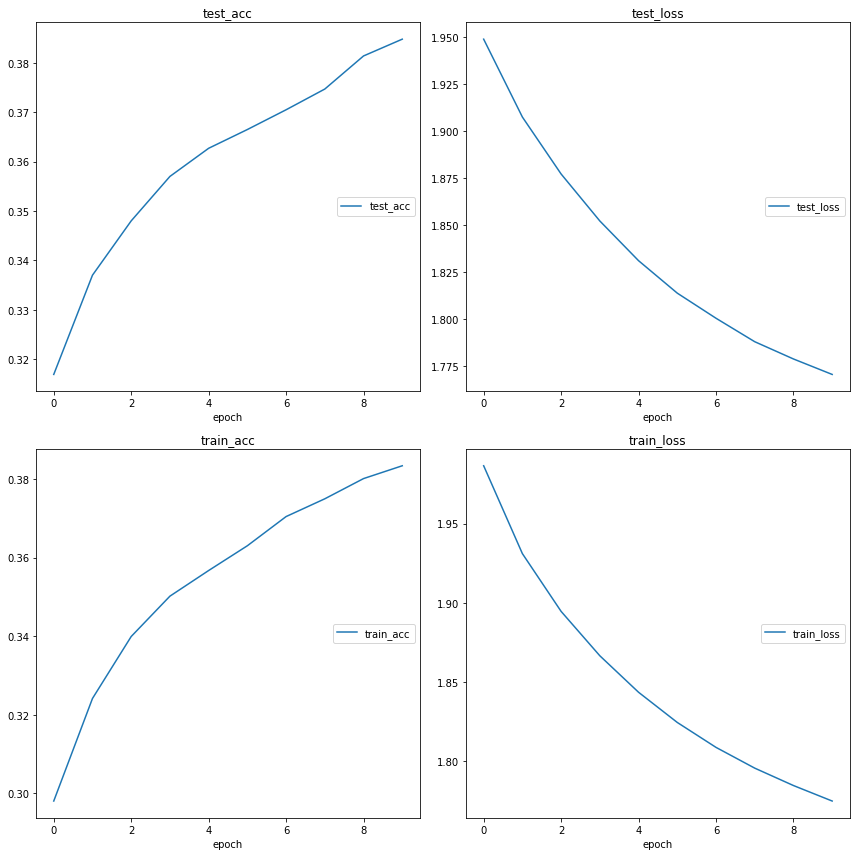

test_acc
	test_acc         	 (min:    0.317, max:    0.385, cur:    0.385)
test_loss
	test_loss        	 (min:    1.771, max:    1.949, cur:    1.771)
train_acc
	train_acc        	 (min:    0.298, max:    0.383, cur:    0.383)
train_loss
	train_loss       	 (min:    1.775, max:    1.987, cur:    1.775)


In [ ]:
epochs = 10

liveloss = PlotLosses()
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch, epochs - 1))
    print("-" * 30)
    
    epoch_loss = {"train": 0.0, "test": 0.0}
    epoch_acc = {"train": 0.0, "test": 0.0}
    
    running_loss = {"train": 0.0, "test": 0.0}
    running_corrects = {"train": 0, "test": 0}
    
    for phase in ["train", "test"]:
        if phase == "train":
            model.train(True)
        else:
            model.train(False)
        
        for data in data_loaders[phase]:
            inputs, labels = data
            # print(inputs.shape)
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad() # clear all gradients
            
            outputs = model(inputs) # batch_size x num_classes
            _, preds = torch.max(outputs.data, 1) # values, indices
            loss = loss_fn(outputs, labels)
            
            if phase == "train":
                loss.backward()  # compute gradients
                optimizer.step() # update weights/biases
               
            running_loss[phase] += loss.data.item() * inputs.size(0)
            running_corrects[phase] += torch.sum(preds == labels.data).item()
        
        epoch_loss[phase] = running_loss[phase] / dataset_sizes[phase]
        epoch_acc[phase] =  running_corrects[phase] / dataset_sizes[phase]

    # Visualize the loss and accuracy values.
    liveloss.update({
        'train_loss': epoch_loss["train"],
        'test_loss': epoch_loss["test"],
        'train_acc': epoch_acc["train"],
        'test_acc': epoch_acc["test"],
    })
    liveloss.draw() 

    #40 ish works

## Visualizing Conv Nets

Now, we will investigate a popular technique for inspecting how CNNs make classification decisions. We look at Guided Grad CAM. We will also see such a method might allow for spotting of adversarial examples

[John]: Essentially, we will simply look at the activations of the convolutional layers (visualized as an image). And we will also look at the gradients. And we will look at the pointwise multiplication of these two maps. 
Note that there are a bunch of layers in AlexNet; we will only be looking at the conv-map from the last layer (layer 11)

How big should filters be? they could get bigger, or they could get smaller. or they could be the same size. It depends. And there are different connectivity structures which are probably more important. 
http://cs231n.github.io/convolutional-networks/

https://www.cs.toronto.edu/~guerzhoy/321/lec/W07/HowConvNetsSee.pdf



### Utilities for Visualization

This code is taken from the following cool repo https://github.com/utkuozbulak/pytorch-cnn-visualizations
Go through it on your own time to understand what is going on, but for now we will just use it to see what we can do with it

In [ ]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('results'):
        os.makedirs('results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((512, 512))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_ten.requires_grad = True
    im_as_var = im_as_ten
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('input_images/snake.jpg', 56),
                    ('input_images/cat_dog.png', 243),
                    ('input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)

    print("program flow")

    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)


def normalize_gradient_image(gradient):
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    
    return gradient

In [ ]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices, however, when I moved the repository to PIL, this
        # option is out of the window. So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, send a PR.
        return cam

In [ ]:
from torch.nn import ReLU

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [ ]:
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask
    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

In [ ]:
!mkdir input_images
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/spider.png?raw=true -O input_images/spider.png
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/dd_tree.jpg?raw=true -O input_images/dd_tree.jpg
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/snake.jpg?raw=true -O input_images/snake.jpg
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/cat_dog.png?raw=true -O input_images/cat_dot.png

### Run Guided Grad Cam Example

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Get params
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example) #pretrained is an alexnet pytorch

print("got here")
# Grad cam
gcv2 = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = gcv2.generate_cam(prep_img, target_class)
print('Grad cam completed')

# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
print('Guided backpropagation completed')

# Guided Grad cam
cam_gb = guided_grad_cam(cam, guided_grads)
cam_gb_norm_orig = normalize_gradient_image(cam_gb)
cam_gb_norm_orig *= 255
cam_gb_norm_orig = Image.fromarray(cam_gb_norm_orig.astype("uint8").transpose(1, 2, 0))

grayscale_cam_gb_orig = convert_to_grayscale(cam_gb)
grayscale_cam_gb_orig = np.repeat(grayscale_cam_gb_orig, 3, axis=0)
grayscale_cam_gb_orig *= 255
grayscale_cam_gb_orig = Image.fromarray(grayscale_cam_gb_orig.astype("uint8").transpose(1, 2, 0))


program flow


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



got here
Grad cam completed
Guided backpropagation completed


Text(0.5, 1.0, 'Grayscale Grad Cam')

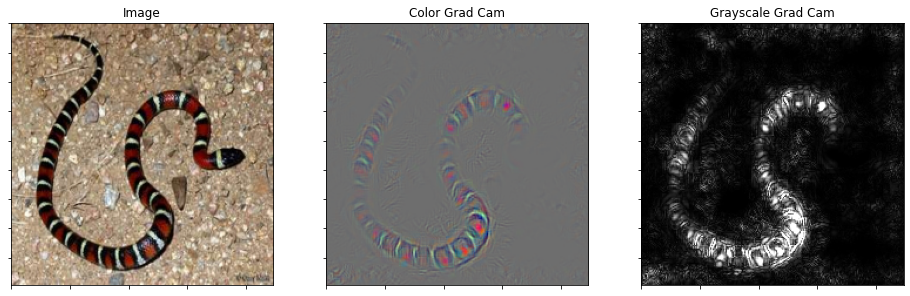

In [ ]:
# Visualize the original image and the gradients
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 3, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
# prep_img.detach().numpy()[0].transpose(1, 2, 0)
ax.imshow(original_image)
ax.set_title("Image")

ax = fig.add_subplot(1, 3, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(cam_gb_norm_orig)
ax.set_title("Color Grad Cam")

ax = fig.add_subplot(1, 3, 3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(grayscale_cam_gb_orig)
ax.set_title("Grayscale Grad Cam")

### Verifying Model Performance

Now let's see if our model predicts the correct class. Anything in the range of 52 to 68 is acceptable since these are all snake classes in ImageNet. If you'd like to see what a numeric class label means, look at: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
original_image
processed_image = preprocess_image(original_image)

In [ ]:
original_output = pretrained_model(processed_image)
_, orig_pred = torch.max(original_output.data, 1)
print("Original Class Prediction: {}".format(orig_pred.item()))

Original Class Prediction: 60


### Creating Adversarial Examples

Note that we are using the simplest attack for this section, namely Fast Gradient Sign. We are also making a very large perturbation so that we can fool the model for sure (epsilon of 0.3 is the largest you'll typically see in the literature). More clever attacks can fool the model by making smaller perturbations.

In [ ]:
class AttackFGS:

    def __init__(
            self,
            targeted=True, max_epsilon=0.21, min_epsilon=1e-10, norm=2,  # also supports 'inf'
            optimize_epsilon=True, num_iter=None, cuda=True, debug=False):

        self.targeted = targeted
        # self.eps = math.exp((math.log(min_epsilon) + math.log(max_epsilon))/2)
        self.eps = max_epsilon
        self.norm = float(norm)
        self.optimize_epsilon = optimize_epsilon
        if self.optimize_epsilon:
            self.num_iter = num_iter or 10

        self.loss_fn = torch.nn.CrossEntropyLoss()
        if cuda:
            self.loss_fn = self.loss_fn.cuda()
        self.debug = debug

    def generate_ad_ex(self, model, inputs, labels, targets=None, batch_num=0):  # Targets are not one hot encoded
        # input_var = Variable(input, requires_grad=True)
        # target_var = Variable(target)
        eps = self.eps

        if self.optimize_epsilon:
            raise NotImplementedError
        else:
            outputs = model(inputs)

            if outputs.is_cuda:
                idxout = torch.LongTensor(range(outputs.size()[0])).cuda()
                xones = torch.ones(outputs.size()[0]).cuda()
            else:
                idxout = torch.LongTensor(range(outputs.size()[0]))
                xones = torch.ones(outputs.size()[0])

            if self.targeted:
                assert targets is not None, "Please pass in targets for a targeted attack!"

                attack_loss = outputs[idxout, targets]
            else:
                # negative sign below gives us correct direction for attack
                attack_loss = -1*outputs[idxout, labels]

            attack_loss.backward(xones)

            grad_sign = torch.sign(inputs.grad)

            delta = eps*grad_sign

            ad_inputs = inputs + delta

        return ad_inputs

In [ ]:
fgs = AttackFGS(targeted=False, optimize_epsilon=False, max_epsilon=0.6)
perturbed_image = fgs.generate_ad_ex(pretrained_model, processed_image, orig_pred)

We can see that now our model will predict the wrong label. In this case, it thinks the image is of a bib!

In [ ]:
perturbed_output = pretrained_model(perturbed_image)
_, adv_pred = torch.max(perturbed_output.data, 1)
print("Perturbed class prediction: {}".format(adv_pred.item()))

Perturbed class prediction: 443


In [ ]:
# Just converting from pytorch tensors to PIL image formatting, undoing the normalization as well
recreated_perturbed = recreate_image(perturbed_image)
print(recreated_perturbed.shape)
type(recreated_perturbed)
recreated_perturbed = Image.fromarray(recreated_perturbed.astype("uint8"))

(224, 224, 3)


Text(0.5, 1.0, 'Adversarial')

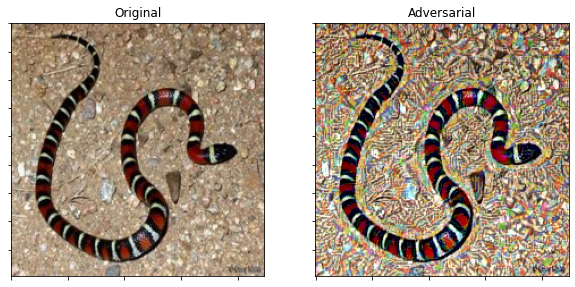

In [ ]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(original_image)
ax.set_title("Original")

ax = fig.add_subplot(1, 2, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(recreated_perturbed)
ax.set_title("Adversarial")

### Grad Cam on Adversarial Example

Now let's see what our model is paying attention to when making this incorrect classification

In [ ]:
# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
prep_img = preprocess_image(recreated_perturbed)
guided_grads = GBP.generate_gradients(prep_img, adv_pred.item())
print('Guided backpropagation completed')

# Guided Grad cam
cam_gb = guided_grad_cam(cam, guided_grads)
cam_gb_norm_adv = normalize_gradient_image(cam_gb)
cam_gb_norm_adv *= 255
cam_gb_norm_adv = Image.fromarray(cam_gb_norm_adv.astype("uint8").transpose(1, 2, 0))

grayscale_cam_gb_adv = convert_to_grayscale(cam_gb)
grayscale_cam_gb_adv = np.repeat(grayscale_cam_gb_adv, 3, axis=0)
grayscale_cam_gb_adv *= 255
grayscale_cam_gb_adv = Image.fromarray(grayscale_cam_gb_adv.astype("uint8").transpose(1, 2, 0))

Guided backpropagation completed


Text(0.5, 1.0, 'Grayscale Grad Cam')

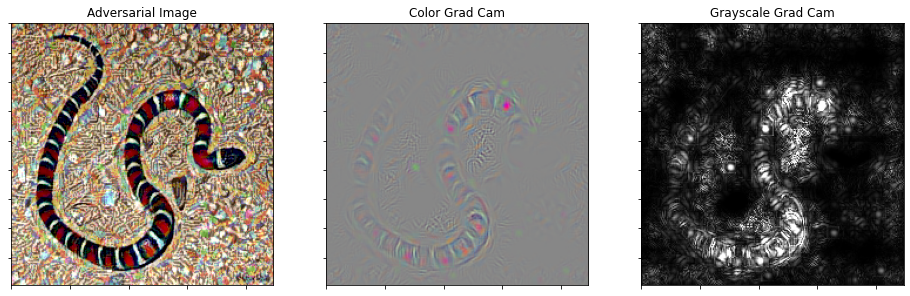

In [ ]:

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 3, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(recreated_perturbed)
ax.set_title("Adversarial Image")

ax = fig.add_subplot(1, 3, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(cam_gb_norm_adv)
ax.set_title("Color Grad Cam")

ax = fig.add_subplot(1, 3, 3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(grayscale_cam_gb_adv)
ax.set_title("Grayscale Grad Cam")

Notice how if you compare these grad cam visualizations to the ones on the original image, these ones have more noise in them and appear more diffuse, i.e. they are less focused on the snake.